## Importing Libraries

In [58]:
import sys, os, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split

In [60]:
#function for ploting history of the model training
from pyspark.sql import Row

def plot_history(history_arg):
    array = []
    i =1
    j =1
    for acc in history_arg.history['acc']:
        array.append(Row(epoch=i, accuracy=float(acc)))
        i = i+1
    acc_df = sqlContext.createDataFrame((array))

    array = []
    for loss in history_arg.history['loss']:
        array.append(Row(epoch = j, loss = float(loss)))
        j = j+1
    loss_df = sqlContext.createDataFrame(array)

    display_df = acc_df.join(loss_df,on=("epoch")).orderBy("epoch")
    return display_df

## Load Data

In [61]:
from pyspark.sql.types import *

toxicWordsTrain=pd.read_csv("D:/Data Science/Machine Learning/Toxic Comments with LSTM-CNN/Toxic-Comment-with-LSTM-CNN/dataset/jigsaw-toxic-comment-classification-challenge/train.csv").fillna(' ')
toxicWordsTest=pd.read_csv("D:/Data Science/Machine Learning/Toxic Comments with LSTM-CNN/Toxic-Comment-with-LSTM-CNN/dataset/jigsaw-toxic-comment-classification-challenge/test.csv").fillna(' ')

#Class labels
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

y_train = toxicWordsTrain[list_classes].values
x_train = toxicWordsTrain["comment_text"]
x_test  = toxicWordsTest["comment_text"]

submission = pd.read_csv("D:/Data Science/Machine Learning/Toxic Comments with LSTM-CNN/Toxic-Comment-with-LSTM-CNN/dataset/jigsaw-toxic-comment-classification-challenge/sample_submission.csv")

# EDA

In [62]:
def overall(df):
    print ("Rows : " ,df.shape[0])
    print ("Columns : " ,df.shape[1])
    print ("\nFeatures : \n" ,df.columns.tolist())
    print ("\nMissing values : ", df.isnull().sum().values.sum())
    print ("\nUnique values : \n", df.nunique())

overall(toxicWordsTrain)

Rows :  159571
Columns :  8

Features : 
 ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Missing values :  0

Unique values : 
 id               159571
comment_text     159571
toxic                 2
severe_toxic          2
obscene               2
threat                2
insult                2
identity_hate         2
dtype: int64


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18204\721643280.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list_classes, y=x.values, palette=palette)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18204\721643280.py:8: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  ax = sns.barplot(x=list_classes, y=x.values, palette=palette)


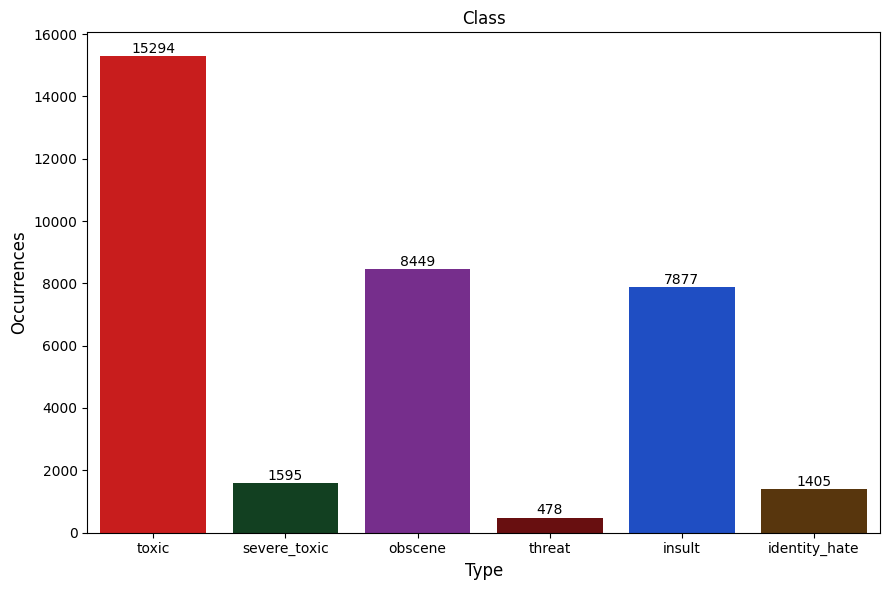

In [12]:
colors_list = ["red", "pine green", "purple", "blood", "blue", "brown", "azure"]

palette = sns.xkcd_palette(colors_list)

x = toxicWordsTrain.iloc[:, 2:].sum() 

plt.figure(figsize=(9, 6))
ax = sns.barplot(x=list_classes, y=x.values, palette=palette) 

plt.title("Class")
plt.xlabel("Type", fontsize=12)
plt.ylabel("Occurrences", fontsize=12)

rects = ax.patches
for rect, label in zip(rects, x.values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 10, int(label),
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [63]:
# Sample from dataset
for sample_i in range(3):
    print('Comment #{}:  {}'.format(sample_i + 1, x_train[sample_i]))
    print('Label #{}:    {}'.format(sample_i + 1, y_train[sample_i]))

Comment #1:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Label #1:    [0 0 0 0 0 0]
Comment #2:  D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Label #2:    [0 0 0 0 0 0]
Comment #3:  Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
Label #3:    [0 0 0 0 0 0]


## Explore Vocabulary

In [64]:
from collections import Counter
from tqdm import tqdm

# Count the frequency of each word across all sentences
word_generator = (word for sentence in tqdm(x_train, desc="Processing sentences") for word in sentence.split())
word_frequency = Counter(word_generator)

# Calculate the total number of words and the number of unique words
total_words = sum(len(sentence.split()) for sentence in x_train)
unique_words_count = len(word_frequency)

# Display the results
print(f'Total number of words: {total_words}')
print(f'Number of unique words: {unique_words_count}')
print('Top 10 most common words in the dataset:')
print('"' + '" "'.join(list(zip(*word_frequency.most_common(10)))[0]) + '"')

Processing sentences: 100%|██████████| 159571/159571 [00:02<00:00, 75560.26it/s]


Total number of words: 10734904
Number of unique words: 532299
Top 10 most common words in the dataset:
"the" "to" "of" "and" "a" "I" "is" "you" "that" "in"


## Preprocessing the data

We preprocess our data a bit so that it's in a format we can input into a neural network. The process includes:

1. Remove irrelevant characters (!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n).
2. Convert all letters to lowercase (HeLlO -> hello).
3. Tokenize our words (hi how are you -> [23, 1, 5, 13]).
4. Standaridize our input length with padding (hi how are you -> [23, 1, 5, 13, 0, 0, 0]).

In [65]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create tokenizer
tokenizer = Tokenizer(num_words=None,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True,
                      split=" ",
                      char_level=False)

# Fit and run tokenizer
tokenizer.fit_on_texts(list(x_train))
tokenized_train = tokenizer.texts_to_sequences(x_train)
tokenized_test = tokenizer.texts_to_sequences(x_test)
word_index = tokenizer.word_index


# Extract variables
vocab_size = len(word_index)
longest = max(len(seq) for seq in tokenized_train)
average = np.mean([len(seq) for seq in tokenized_train])
stdev = np.std([len(seq) for seq in tokenized_train])
max_len = int(average + stdev * 3)

print('Vocab size: {}'.format(vocab_size))
print("Longest comment size: {}".format(longest))
print("Average comment size: {}".format(average))
print("Stdev of comment size: {}".format(stdev))
print('Max comment size: {}'.format(max_len))

Vocab size: 210337
Longest comment size: 1403
Average comment size: 68.22156908210138
Stdev of comment size: 101.07344657013672
Max comment size: 371


In [66]:
# Pad sequences
processed_X_train = pad_sequences(tokenized_train, maxlen=max_len, padding='post', truncating='post')
processed_X_test = pad_sequences(tokenized_test, maxlen=max_len, padding='post', truncating='post')

# Sample tokenization
for sample_i, (sent, token_sent) in enumerate(zip(x_train[:2], tokenized_train[:2])):
    print('Sequence {}'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

Sequence 1
  Input:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
  Output: [688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]
Sequence 2
  Input:  D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
  Output: [96145, 52, 2635, 13, 555, 3809, 73, 4556, 2706, 21, 94, 38, 803, 2679, 992, 589, 8377, 182]


In [68]:
print(processed_X_train.shape)
print(y_train.shape)

(159571, 371)
(159571, 6)


After preprocessing, our vocabulary size drops to a more manageable 210,337 with a max comment size of 371 words and an average comment size of about 68 words per sentence

### Word Embedding

In [69]:
embedding_dim=300
embedding_index = {}
f = open('D:/Data Science/Machine Learning/Toxic Comments with LSTM-CNN/Toxic-Comment-with-LSTM-CNN/wiki.en.vec', encoding = 'utf8')

for line in f:
    values = line.rstrip().rsplit(' ', embedding_dim)
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32') 
    embedding_index[word] = coefs
f.close()

print('Found {} word vectors.'.format(len(embedding_index)))

Found 2519371 word vectors.


### Build Embedding Matrix

In [70]:
# Build embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [71]:
import keras.backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dropout, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Nadam

from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras import initializers, regularizers, constraints, optimizers, layers


In [72]:
# Initate model
model = Sequential()

# Add Embedding layer
model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))

# Add Recurrent layer
model.add(LSTM(60, return_sequences=True, name='lstm_layer'))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(3))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())

# Add fully connected layers
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='sigmoid'))

model.build(input_shape=(None, 371))
# Summarize the model
model.summary()

C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 371, 300)       │    63,101,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 371, 60)        │        86,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 371, 128)       │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 123, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,233,836 (241.22 MB)

 Trainable params: 63,233,580 (241.22 MB)

 Non-trainable params: 256 (1.00 KB)

In [73]:
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras import backend as K

# Define custom loss function
def loss(y_true, y_pred):
    return K.binary_crossentropy(y_true, y_pred)

# Define learning rate
learning_rate = 0.0001

# Compile the model
model.compile(
    loss=loss,
    optimizer=Nadam(learning_rate=learning_rate, clipnorm=1.0),
    metrics=['binary_accuracy']
)


In [74]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.keras.callbacks import Callback

In [75]:
print(processed_X_train.shape)
print(y_train.shape)

(159571, 371)
(159571, 6)


In [76]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
import numpy as np

class RocAucEvaluation(Callback):
    def __init__(self, filepath, validation_data=(), interval=1, max_epoch=100):
        super(RocAucEvaluation, self).__init__()
        self.filepath = filepath
        self.interval = interval
        self.best = 0
        self.stopped_epoch = max_epoch
        self.X_val, self.y_val = validation_data
        self.y_pred = np.zeros(self.y_val.shape)

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        if epoch % self.interval == 0:
            # Use predict instead of predict_proba
            y_pred = self.model.predict(self.X_val, verbose=0)
            current = roc_auc_score(self.y_val, y_pred)

            logs['roc_auc_val'] = current  # Update logs for metrics tracking

            if current > self.best:
                print(f" - AUC improved from {self.best:.5f} to {current:.5f}")
                self.best = current
                self.y_pred = y_pred
                self.stopped_epoch = epoch + 1
                self.model.save(self.filepath, overwrite=True)
            else:
                print(f" - AUC did not improve from {self.best:.5f}")

# Example of usage
from sklearn.model_selection import train_test_split

# Assuming `processed_X_train` and `y_train` are already defined
X, X_val, y, y_val = train_test_split(processed_X_train, y_train, test_size=0.03, shuffle=False)

# Initialize callback
roc_auc_callback = RocAucEvaluation(filepath='model.best.hdf5', validation_data=(X_val, y_val), interval=1)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(loss='binary_crossentropy', optimizer='Adam')

# Set variables
batch_size = 64
epochs = 3

# Set early stopping
early_stop = EarlyStopping(monitor="roc_auc_val", mode="max", patience=2)
                                                    
# Train
graph = model.fit(X, y, batch_size=batch_size, epochs=epochs,
                  validation_data=(X_val, y_val), 
                  callbacks=[roc_auc_callback, early_stop],
                  verbose=1, shuffle=False)